In [2]:
!pip install pygmsh
!pip install solidspy
!pip install easygui
!pip install meshio

In [4]:
import pygmsh
import matplotlib.pyplot as plt
from solidspy import solids_GUI 
import pandas as pd

# Generate mesh

## load geometry

In [6]:
points = pd.read_csv("points.csv")

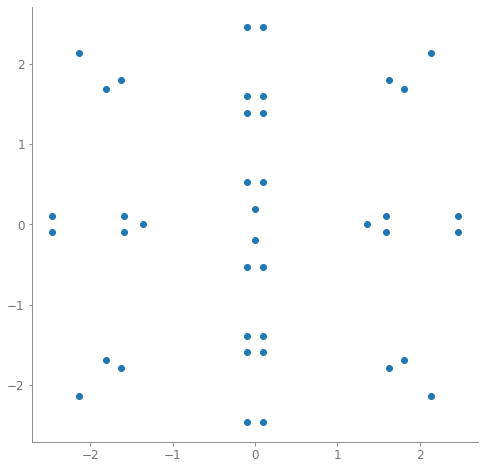

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(points.x, points.y)
plt.show()

## read parts

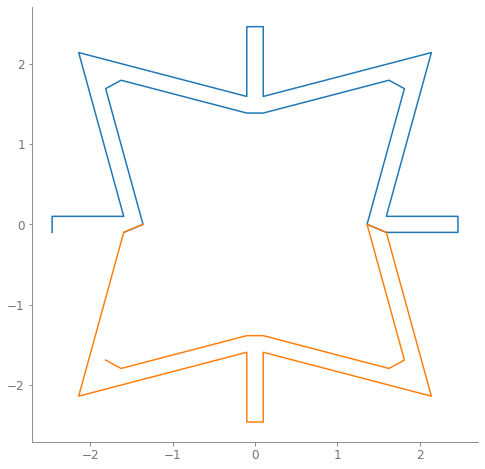

In [52]:
pt1 = pd.read_csv("pt1.csv")
pt2 = pd.read_csv("pt2.csv")
plt.figure(figsize=(8,8))
plt.plot(pt1.x, pt1.y)
plt.plot(pt2.x, pt2.y)
plt.show()

In [37]:
pt.values

array([[-2.46410162e+00, -1.00000000e-01],
       [-2.46410162e+00,  1.00000000e-01],
       [-1.59442415e+00,  1.00000000e-01],
       [-2.14142136e+00,  2.14142136e+00],
       [-1.00000000e-01,  1.59442415e+00],
       [-1.00000000e-01,  2.46410162e+00],
       [ 1.00000000e-01,  2.46410162e+00],
       [ 1.00000000e-01,  1.59442415e+00],
       [ 2.14142136e+00,  2.14142136e+00],
       [ 1.59442415e+00,  1.00000000e-01],
       [ 2.46410162e+00,  1.00000000e-01],
       [ 2.46410162e+00, -1.00000000e-01],
       [ 1.59442415e+00, -1.00000000e-01],
       [ 1.36057400e+00, -3.13000000e-16],
       [ 1.81391480e+00,  1.69189090e+00],
       [ 1.62641646e+00,  1.79637098e+00],
       [ 1.00000000e-01,  1.38736892e+00],
       [-1.00000000e-01,  1.38736892e+00],
       [-1.62641646e+00,  1.79637098e+00],
       [-1.81391480e+00,  1.69189090e+00],
       [-1.36057400e+00, -7.36000000e-16],
       [-1.59442415e+00, -1.00000000e-01]])

In [53]:
with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(
        pt1.values,
        mesh_size=0.1
    )
    geom.add_polygon(
        pt2.values,
        mesh_size=0.1
    )
    mesh = geom.generate_mesh()
mesh_pts = mesh.points

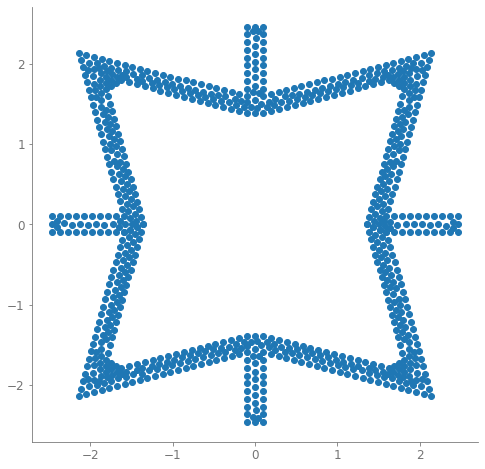

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(mesh_pts[:,0], mesh_pts[:,1])
plt.show()

# Write input files

## 1. Write nodes.txt
- Column 0: Nodal identifier (integer).
- Column 1: x-coordinate (float).
- Column 2: y-coordinate (float).
- Column 3: Boundary condition flag along the x-direction (0 free, -1 restrained).
- Column 4: Boundary condition flag along the y-direction (0 free, -1 restrained).

```
0  0.00  0.00   0  -1
1  2.00  0.00   0  -1
2  2.00  2.00   0   0
3  0.00  2.00   0   0
4  1.00  0.00  -1  -1
5  2.00  1.00   0   0
6  1.00  2.00   0   0
7  0.00  1.00   0   0
8  1.00  1.00   0   0
```

In [55]:
# fix bottom
with open('nodes.txt', 'w') as f_nodes:
    for i, point in enumerate(mesh_pts):
        if point[1] == min(mesh_pts[:, 1]):
            bc_x, bc_y = -1, -1
        else:
            bc_x, bc_y = 0, 0
        f_nodes.write(f"{i:4} {point[0]:8.4f} {point[1]:8.4f}  {bc_x:4}  {bc_y:4} \n")

## 2. Write eles.txt
- Column 0: Element identifier (integer).
- Column 1: Element type (integer):
    - 1 for a 4-noded quadrilateral.
    - 2 for a 6-noded triangle.
    - 3 for a 3-noded triangle.
- Column 2: Material profile for the current element (integer).
- Column 3 to end: Element connectivity, this is a list of the nodes conforming each element. The nodes should be listed in **counterclockwise** orientation.

```
0   1   0   0   4   8   7
1   1   0   4   1   5   8
2   1   0   7   8   6   3
3   1   0   8   5   2   6
```

In [56]:
elements = mesh.cells_dict['triangle']
with open('eles.txt', 'w') as f_eles:
    for i, element in enumerate(elements):
        f_eles.write(f"{i:4}   3   0  {element[0]:4} {element[1]:4}  {element[2]:4} \n")

## 3. mater.txt
- Column 0: Young’s modulus for the current profile (float).
- Column 1: Poisson’s ratio for the current profile (float).
```
1.0  0.3
```

In [57]:
E = 1.0
nu = 0.3
with open('mater.txt', 'w') as f_mater:
    f_mater.write(f"{E:8.4f} {nu:8.4f}")

## 4. loads.txt
- Column 0: Nodal identifier (integer).
- Column 1: Load magnitude for the current node along the x-direction (float).
- Column 2: Load magnitude for the current node along the y-direction (float).
```
3  0.0  1.0
6  0.0  2.0
2  0.0  1.0
```

In [58]:
# load top
load = -2.0
with open('loads.txt', 'w') as f_loads:
    for i, point in enumerate(mesh_pts):
        if point[1] == max(mesh_pts[:, 1]):
            f_loads.write(f"{i:4} {0.0:8.4f} {load:8.4f} \n")

# Run FE simulation

In [ ]:
disp = solids_GUI()  # run the Finite Element Analysis
plt.show()    # plot contours